# Demo 3

The lab this week is a continuation of the previous week. We will use the training dataset that we generated last week to classify every pixel in our remote sensing image. Then we will evaluate our classification using a confusion matrix. 

```{note}
I forgot to tell you to save the training dataset last week. So you will need to re-run your code for that assignment and save the training dataset using `training_data.to_csv('data/training_dataset.csv')`
```

In [1]:
# Import packages
import glob
import rasterio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import training dataset
training_data = pd.read_csv('data/training_dataset.csv')
training_data.head()

,band1,band2,band3,band4,band5,band6,band7,labels
0,8285,8488,9276,9774,13948,16238,12979,1
1,8320,8529,9257,9797,14101,16360,13168,1
2,8404,8623,9381,9907,14222,16337,13152,1
3,8740,9015,9852,10619,14269,17921,14906,1
4,8510,8727,9620,10169,14885,16912,13714,1


## Classification

### K-nearest Neighbors

We will start with a simple [K-nearest neighbors classifcation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#kneighborsclassifier). This approach will classify new "unseen" points by finding the K closest labelled points. The main decision we have to make is the number of neighbors (i.e. `n_neighbors`) which defaults to 5 but can be customized. The standard version of this algorithm will then use a majority vote to determine which class to assign the new point (hence we typically set K to an odd value). 

### Split training and testing data

The K-nearest neighbors classifcation can be accessed using a package called `scikit-learn`. But before we do that, we need to format our training dataset into separate features (`X`) and labels (`y`).

In [2]:
X = training_data[['band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7']]
y = training_data['labels']

We also need to separate our data in training and testing data. Our testing data will not be used to train the classifier so we can use it to independently evaluate the classifier's performance. In the code below, we will reserve 20% of the data for testing (i.e. `test_size=0.2`). 

In [3]:
from sklearn.model_selection import train_test_split

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

````{margin}
```{note}
The [`random_state`](https://scikit-learn.org/stable/glossary.html#term-random_state) argument controls the shuffling applied to the data before applying the split. We can pass an `int` for reproducible output across multiple function calls. 
```
````

### Define classifier, fit classifier, and predict labels

Now we can apply the K-nearest neighbors classifier to our training data like so:

In [4]:
from sklearn.neighbors import KNeighborsClassifier

# Define classifier
knn = KNeighborsClassifier(n_neighbors=11)

# Fit classifier
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)
y_pred

array([5, 3, 5, ..., 5, 5, 5], shape=(1373,))

### Evaluate classifier

The `y_pred` variable contains a list of **predicted** labels for each row of the testing dataset. We can compare these predicted labels to the actual labels using a **confusion matrix** to understand how our classifier is performing. 

In [5]:
from sklearn.metrics import confusion_matrix

# Define class labels
class_labels = ['cleared', 'forest', 'grass', 'lake', 'ocean', 'river', 'sand']

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Convert to DataFrame
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

# Rename index and columns for clarity
cm_df.index.name = "Actual"
cm_df.columns.name = "Predicted"
cm_df

Predicted,cleared,forest,grass,lake,ocean,river,sand
Actual,,,,,,,
cleared,175,0,6,0,0,0,0
forest,0,133,0,0,0,0,0
grass,1,0,173,0,0,0,0
lake,0,0,0,138,0,1,0
ocean,0,0,0,0,603,0,0
river,0,0,0,0,0,83,0
sand,0,0,0,0,0,0,60


It looks like the classification did a pretty good job. Although our confusion matrix shows that our classifier mislabelled **6 points** as `grass` when they should have been `cleared`. It also mislabelled one point as `cleared` when it should have been `grass`. 

`sklearn` has a function for computing the errors of commission and omission although it terms them **precision** and **recall**. 

In [6]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

precisions = precision_score(y_test, y_pred, average=None)
recalls = recall_score(y_test, y_pred, average=None)

In [7]:
error_df = pd.DataFrame(list(zip(precisions, recalls)), index=class_labels, columns=['precision', 'recall'])
error_df

,precision,recall
cleared,0.994318,0.966851
forest,1.000000,1.000000
grass,0.966480,0.994253
lake,1.000000,0.992806
ocean,1.000000,1.000000
river,0.988095,1.000000
sand,1.000000,1.000000


Finally, we can find the overall accuracy of our classifier like so:

In [8]:
overall_accuracy = accuracy_score(y_test, y_pred)
overall_accuracy

0.9941733430444283

### Classify whole image

Since our classifier is performing pretty accurately according to our testing data, we can go ahead and classify every pixel in our Landat image. To do this, we first have to import all the **features** that our classifier used. In this case, this is just the seven bands from the image. But note that if the classifier was trained on a spectral index, then we would have to import that as well.

In [9]:
# Define list of Landsat bands
files = sorted(glob.glob('data/landsat/*.tif'))

# Function to read a GeoTIFF file and return as a flattened array
def read_geotiff(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1).flatten()

# Read each GeoTIFF file and store the data in a dictionary
data = {f'band{i+1}': read_geotiff(file) for i, file in enumerate(files)}

# Create DataFrame
df = pd.DataFrame(data)
df.shape

(1717776, 7)

Each row of this DataFrame is a pixel in the Landsat image. We can predict the label of each pixel using our pre-trained classifier. 

````{margin}
```{note}
The DataFrame must have the same column names as the `X_train` variable.
```
````

In [10]:
y_pred = knn.predict(df)

````{margin}
```{note}
This may take a few minutes.
```
````

The variable `y_pred` is now a list of labels for each row, which we can add as a column to the original DataFrame.

In [11]:
df['labels'] = y_pred
df.head()

,band1,band2,band3,band4,band5,band6,band7,labels
0,0,0,0,0,0,0,0,6
1,0,0,0,0,0,0,0,6
2,0,0,0,0,0,0,0,6
3,0,0,0,0,0,0,0,6
4,0,0,0,0,0,0,0,6


One problem here is that the **NoData** values of the Landsat image (represented as zeros) are classified as **label 6**. It would be more sensible to classify these values as **zero**.

In [12]:
# Set labels to zero where values in band 1 are equal to zero
df.loc[df['band1'] == 0, 'labels'] = 0

We can now `reshape` the labels column to the original 2D shape of the Landsat image. 

In [13]:
# Find shape of one Landsat band
src = rasterio.open(files[0])

# Reshape
y_pred_2d = df['labels'].values.reshape(src.shape)
y_pred_2d.shape

(1422, 1208)

### Plot

We can qualitatively inspect our classification by plotting as a map with each class as a different color.

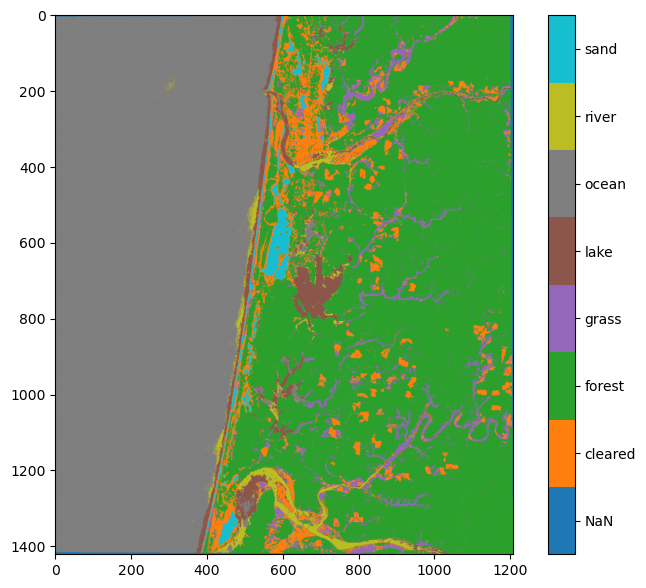

In [14]:
import matplotlib.ticker as ticker

# Define a colormap with seven distinct colors
cmap = plt.get_cmap('tab10', 8)

# Define new class labels
class_labels = ['NaN', 'cleared', 'forest', 'grass', 'lake', 'ocean', 'river', 'sand']

# Plot the classified image
plt.figure(figsize=(9, 7))
im = plt.imshow(y_pred_2d, cmap=cmap, vmin=0, vmax=7)
cbar = plt.colorbar(im, ticks=np.arange(8))

# Center the labels in the colorbar
tick_locs = (np.arange(8) + 0.5) * (7 / 8)
cbar.ax.yaxis.set_major_locator(ticker.FixedLocator(tick_locs))
cbar.ax.yaxis.set_major_formatter(ticker.FixedFormatter(class_labels))

plt.show()

Even though our testing dataset revealed that the accuracy of our classification was >99%, there are clearly errors. It looks like some of the `river` was classified as `lake`, and some of the `ocean` near the land was classified as `river` or `lake`. This is not surprising given the lack of separability between these three classes that we identified in the previous demo. Clearly our training dataset does not represent the full spectral range of these classes. We should go back into QGIS and digitize more training data in these areas to see if we can do a better job of classifying them. 

### Export as GeoTIFF

We can refine our training dataset in QGIS. But first it would be useful export our first classification attempt as a GeoTIFF to see where the errors are.

In [15]:
with rasterio.open(
        "data/classified.tif",
        mode="w",
        driver="GTiff",
        height=y_pred_2d.shape[0],
        width=y_pred_2d.shape[1],
        count=1,
        dtype=y_pred_2d.dtype,
        crs=src.crs,
        transform=src.transform,
) as new_dataset:
        new_dataset.write(y_pred_2d, 1)

This is the end of the demo.